# Background

The following sources may be particularly relevant for this assignment:
- Tutorials:
    - Forward models and source spaces: Head model and forward computation
- Examples:
    - Visualization: Plotting with `mne.viz.Brain`

## General instructions
- Name your notebook `firstname-lastname-A2.ipynb`; e.g., `christian-brodbeck-A2.ipynb`
- Document your code: explain what it is doing
- Use the qestion identifiers in your answer ("1.1", "A" etc.)
- Before submitting, restart the kernel and re-run the whole notebook. This is to make sure your code runs in the sequence you are handing in. We want to see cell execution order numbers 1, 2, ....
- Submit an `ipynb` and a `pdf` version of your final notebook
- This is meant as an individual assignment and what you hand in should be your work
- Please do not use AI; you should be able to justify/explain what you write; if you have questions, please ask us

# Setup
Use the same setup as in Assignment 1.

In [117]:
!pip install mne


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## 1. Forward model

We will work with the subject called "sample". This is a head model based on an MRI from the same person as the data in Assignment 1.

Create a source space with `ico4` spacing (distributing virtual current sources on the cortical surface, based on a 4 times recursively subdivided icosahedron; use `add_dist=False` to reduce the time this takes).
Plot the source space using `mne.viz.plot_bem`.
Create a 3-layer BEM model (we will use this for EEG as well).
Compute a forward solution using a fixed orientation constraint, 
i.e., including only dipoles that are orthognal to the cortical surface.
Extract the leadfield.

In [118]:
import mne
from mne.datasets import sample

# load the sample dataset
data_path = sample.data_path()
# the raw file containing the channel location + types
sample_dir = data_path / "MEG" / "sample"
raw_fname = sample_dir / "sample_audvis_raw.fif"
# paths to Freesurfer reconstructions
subjects_dir = data_path / "subjects"
subject = "sample"


***Source space*** defines the position and orientation of the source locations. 
Two types:
- surface based: candidate source locations are confined to a surface
- volumetric/discrete: candidates are discrete, located arbitrarily and bounded by the surface
in this case we are focusing on the cortical surface sources.

In [119]:
# create source space with ico4 spacing
src = mne.setup_source_space(
    subject, spacing="ico4", add_dist="False", subjects_dir=subjects_dir
)
print(src)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/rawanmahdi/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/155407 selected to source space (ico = 4)

Loading /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 25

Using surface: /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/bem/inner_skull.surf
Using surface: /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/bem/outer_skull.surf
Using surface: /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/bem/outer_skin.surf


/Users/rawanmahdi/Documents/cognitive-neuro/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


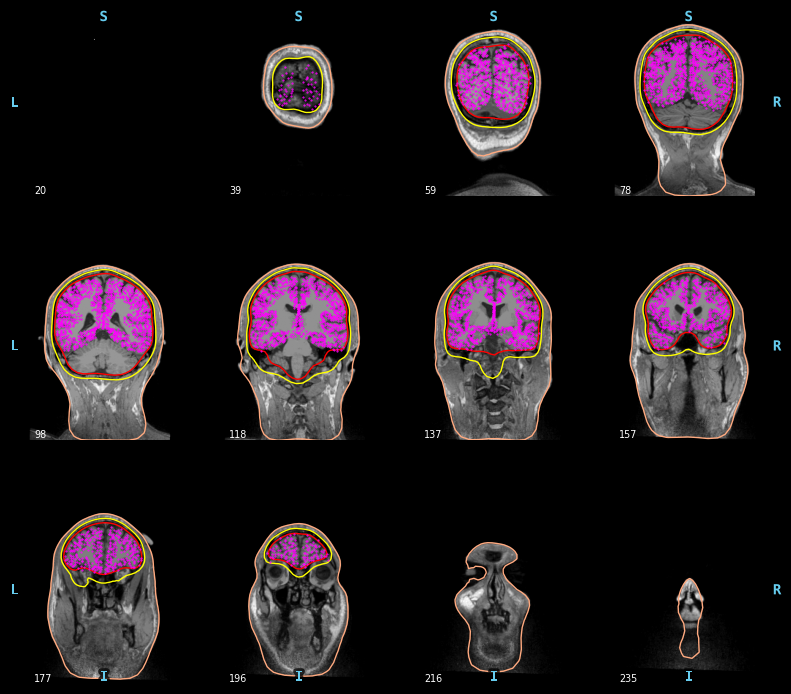

In [120]:
# plotting the computed source space on the subject
mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir, src=src)

***BEM***: Boundary element model, representation of the surfaces that define compartments of tissues of the head .

In [121]:
# creating the 3 layer BEM Model
# define the conductivity for the three tissue types
conductivity = (0.3, 0.006, 0.3)  # (inner skull, outer skull, and scalp)
model = mne.make_bem_model(
    subject="sample", ico=4, conductivity=conductivity, subjects_dir=subjects_dir
)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
outer skin  CM is  -0.12  -0.14  22.79 mm
outer skull CM is   0.70  -9.88  44.01 mm
inner skull CM is   0.67 -10.01  44.26 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    3.7 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    3.5 mm
Surfaces passed the basic topology checks.
Complete.

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        

***The Forward Model***: i.e. the leadfield matrix, describes the relationship between the electrical sources in the brain and the resulting current measured at the scalp  sensors. Represented as matrix L, where each entry (Lij) represents the potential measured at a electrode (i) due to a specific source dipoles (j).

In [122]:
trans = sample_dir / "sample_audvis_raw-trans.fif"
# compute the leadfield matrix 
fwd = mne.make_forward_solution(
    raw_fname,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=True,
    mindist=5.0,
    n_jobs=None,
    verbose=True,
)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=2562>, <surface (rh), n_vertices=156866, n_used=2562>] MRI (surface RAS) coords, subject 'sample', ~33.0 MiB>
MRI -> head transform : /Users/rawanmahdi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw-trans.fif
Measurement data      : sample_audvis_raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 5124 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999310 0.009985 -0.035787      -3.17 mm
    0.012759 0.812405 0.582954       6.86 mm
    0.034894 -0.583008 0.811716      28.88 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.991420 -0.039936 -0.124467      -6.13 mm
    0.060661 0.984012 0.167456       0.06 mm
    0.115790 -0.173570 0.9779

In [123]:
# extract the forward operator corresponding to sources orthogonal to brain surface
fwd_fixed = mne.convert_forward_solution(
    fwd, surf_ori=True, force_fixed=True, use_cps=True
)
# extract leadfield
leadfield = fwd_fixed["sol"]["data"]
print(f"Leadfield size : {leadfield.shape[0]} sensors x {leadfield.shape[1]} dipoles")

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 366 sensors x 4699 dipoles


**A.** Use the leadfield to simulate the following sources:

- Equal current in all sources in the left transverse temporal gyrus (primary auditory cortex)
- Same for the right transverse temporal gyrus

Hints:

 - Use `mne.read_labels_from_annot` to load the `"aparc"` parcellation
 - Visualize the labels to see them on the specific brain (the plots may open in a separate window and not be visible in the notebook, that's okay for the assignment); you can find a generic map in [Desikan et al., 2006](https://doi.org/10.1016/j.neuroimage.2006.01.021)
 - The anatomical model we are using is coming from the FreeSurfer software.
   The cortical surface of each hemisphere is modeled as a collection of vertices.
   Each vertex has a unique integer ID *within a hemisphere* (but the same ID may appear in the two hemispheres).
 - In `mne.Label` objects, the vertex ID of the vertices belonging to the label is stored as `label.vertices`.
 - The source space is defined on a subset of the vertices, i.e., each source is located at the location of a vertex. You can access vertex ID in `fwd_fixed['src'][0]['vertno']` (LH) and `fwd_fixed['src'][1]['vertno']` (RH)
 - Note that the `leadfield` concatenates LH and RH (in this order), whereas the `SourceSpace` represents these separately.

### Left & Right Transverse Temporal Gyrus Simulation

In [124]:
import numpy as np

# read all left hemisphere labels from parcellations 
labels = mne.read_labels_from_annot(subject=subject, subjects_dir=subjects_dir, parc="aparc", hemi="lh")

# get vertices for left transverse temporal gyrus
l_tvt_vertices = [label.vertices for label in labels if label.name == "transversetemporal-lh" ][0]
print(f"Found {len(l_tvt_vertices)} vertices representing sources in left transverse temporal gyrus.")

# find indices of vertices we want in source space
l_idx_src = np.where(np.in1d(fwd_fixed['src'][0]['vertno'], l_tvt_vertices))[0]
print(f"Found {len(l_idx_src)}")

# create source currents matrix of size (n_sources, 1)
J_lh = np.zeros((fwd['nsource'], 1))  # Add in single time point dimension

# simulate equal currents of 1 in the target regions
J_lh[l_idx_src] = 1

# use dot product to compute the desired sensor activations
Y_lh = leadfield @ J_lh


Reading labels from parcellation...
   read 34 labels from /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
Found 770 vertices representing sources in left transverse temporal gyrus.
Found 13


/var/folders/nc/99f_45_901x0qhcldskbqy880000gn/T/ipykernel_73211/1087841283.py:11: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  l_idx_src = np.where(np.in1d(fwd_fixed['src'][0]['vertno'], l_tvt_vertices))[0]


In [128]:

# read all left hemisphere labels from parcellations 
labels = mne.read_labels_from_annot(subject=subject, subjects_dir=subjects_dir, parc="aparc", hemi="rh")

# get vertices for left transverse temporal gyrus
r_tvt_vertices = [label.vertices for label in labels if label.name == "transversetemporal-rh" ][0]
print(f"Found {len(r_tvt_vertices)} vertices representing sources in right transverse temporal gyrus.")

# find indices of vertices we want in source space
r_idx_src = np.where(np.in1d(fwd_fixed['src'][1]['vertno'], r_tvt_vertices))[0]
print(f"Found {len(r_idx_src)} sources corresponding to right transverse temporal gyrus.")

# create source currents matrix of size (n_sources, 1)
J_rh = np.zeros((fwd['nsource'], 1))  # Add in single time point dimension

# simulate equal currents of 1 in the target regions
J_rh[r_idx_src] = 1

# use dot product to compute the desired sensor activations
Y_rh = leadfield @ J_rh

Reading labels from parcellation...
   read 34 labels from /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Found 733 vertices representing sources in right transverse temporal gyrus.
Found 13 sources corresponding to right transverse temporal gyrus.


/var/folders/nc/99f_45_901x0qhcldskbqy880000gn/T/ipykernel_73211/2562411570.py:9: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  r_idx_src = np.where(np.in1d(fwd_fixed['src'][1]['vertno'], r_tvt_vertices))[0]


**B.** Visualize the resulting head maps, each for EEG and MEG (magnetometers).

Hint: Re-uniting the sensors in the lead field with the original sensor location information (needed for plotting) is not as straight foward as you would hope. You can use this approach:

1. Load the raw data the forward solution is based on as `raw`
2. Find the relevant channels with `ch_index = mne.pick_types(raw.info, meg=True, eeg=True, exclude=[])`
3. You can now extract the information for those channels with `info = mne.pick_info(raw.info, ch_index)`
4. You can now create an `mne.EvokedArray` object, pretending the the simulation is an evoked response with a single time point
5. This will allow you to use `evoked.plot_topomap()`

### Left Transverse Temporal Gyrus Simulation Head Maps

Opening raw data file /Users/rawanmahdi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


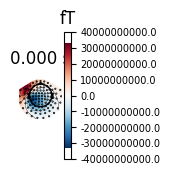

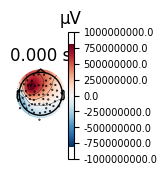

In [129]:
# get channel indices
raw = mne.io.read_raw_fif(raw_fname, preload=False)
ch_index = mne.pick_types(raw.info, meg=True, eeg=True, exclude=[])
info = mne.pick_info(raw.info, ch_index)

# add single time point dimension
Y_lh = Y_lh.reshape(-1, 1)  

# create evoked object across single time point 
evoked_left = mne.EvokedArray(Y_lh, info, tmin=0)

# MEG 
lh_plot = evoked_left.plot_topomap(times=0, ch_type='mag')

# EEG 
lh_plot = evoked_left.plot_topomap(times=0, ch_type='eeg')


### Right Transverse Temporal Gyrus

Opening raw data file /Users/rawanmahdi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


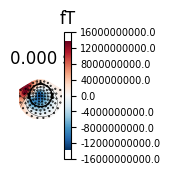

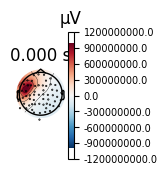

In [130]:
# Get channel indices
raw = mne.io.read_raw_fif(raw_fname, preload=False)
ch_index = mne.pick_types(raw.info, meg=True, eeg=True, exclude=[])
info = mne.pick_info(raw.info, ch_index)

# Add single time point dimension
Y_rh = Y_rh.reshape(-1, 1)  

# create evoked object across single time point 
evoked_right = mne.EvokedArray(Y_rh, info, tmin=0)

# MEG 
rh_plot = evoked_right.plot_topomap(times=0, ch_type='mag')

# EEG
rh_plot = evoked_right.plot_topomap(times=0, ch_type='eeg')

**C.** Do the same for the left and right pericalcarine labels (primary visual cortex).

Reading labels from parcellation...
   read 34 labels from /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 34 labels from /Users/rawanmahdi/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot


/var/folders/nc/99f_45_901x0qhcldskbqy880000gn/T/ipykernel_73211/2445247656.py:9: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  l_idx_src = np.where(np.in1d(fwd_fixed['src'][0]['vertno'], l_p_vertices))[0]
/var/folders/nc/99f_45_901x0qhcldskbqy880000gn/T/ipykernel_73211/2445247656.py:10: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  r_idx_src = np.where(np.in1d(fwd_fixed['src'][1]['vertno'], r_p_vertices))[0]


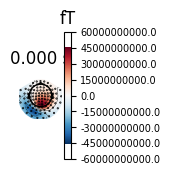

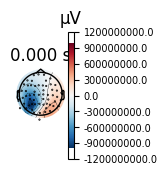

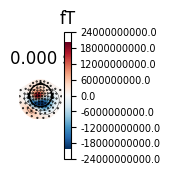

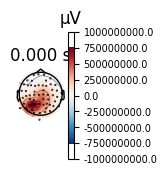

In [132]:

# read all left hemisphere labels from parcellations 
labels = mne.read_labels_from_annot(subject=subject, subjects_dir=subjects_dir, parc="aparc")

# get vertices for left transverse temporal gyrus
l_p_vertices = [label.vertices for label in labels if label.name == "pericalcarine-lh" ][0]
r_p_vertices = [label.vertices for label in labels if label.name == "pericalcarine-lh" ][0]

# find indices of vertices we want in source space
l_idx_src = np.where(np.in1d(fwd_fixed['src'][0]['vertno'], l_p_vertices))[0]
r_idx_src = np.where(np.in1d(fwd_fixed['src'][1]['vertno'], r_p_vertices))[0]

# create source currents matrix of size (n_sources, 1)
J_lh = np.zeros((fwd['nsource'], 1))  # Add in single time point dimension
J_rh = np.zeros((fwd['nsource'], 1))  # Add in single time point dimension

# simulate equal currents of 1 in the target regions
J_lh[l_idx_src] = 1
J_rh[r_idx_src] = 1

# use dot product to compute the desired sensor activations
Y_lh = leadfield @ J_lh
Y_rh = leadfield @ J_rh

# plot as before 
Y_lh = Y_lh.reshape(-1, 1)  
Y_rh = Y_rh.reshape(-1, 1)  

evoked_left = mne.EvokedArray(Y_lh, info, tmin=0)
evoked_right = mne.EvokedArray(Y_rh, info, tmin=0)

# MEG Magnetometers
lh_plot = evoked_left.plot_topomap(times=0, ch_type='mag')
lh_plot = evoked_left.plot_topomap(times=0, ch_type='eeg')
rh_plot = evoked_right.plot_topomap(times=0, ch_type='mag')
rh_plot = evoked_right.plot_topomap(times=0, ch_type='eeg')


**D.** Compare the head maps created in **B** and **C**  to the results from the evoked potential/field analysis from Assignment 1. 

**Comparison:**
In the head maps created in B and C, we see a much higher spatial resolution in the EEG plots in comparison to the topomaps from the evoked potential from assignment 1. Specifically, we are able to see denser current sources in the EEG topomaps focused on a specific brain area. This is most likely because the leadfield matrix (through the BEM) attempts to account for the conductivities of scalp tissue that interfere with the signals recorded via EEG. We don't however see a big difference between the topomap resolutions for MEG recordings, and this is most likely because MEG recordings are largely unaffected by scalp conductivities. 